<br/>

# <font color=teal>Ecommerce Shopping Project</font>

This project is based on the Amazon KDD Cup 2023 challenge to classify customer shopping queries as related or not related to product descriptions

find the challenge [Here](https://www.aicrowd.com/challenges/amazon-kdd-cup-23-multilingual-recommendation-challenge)


<br/>

<br/>


---

<br/>


<br/>


### <font color=orange>Goal</font>

<br/>


TBD

<br/>

<br/>


### <font color=orange>Input</font>

<font color=purple>Local tokenized data </font>

Data nlp directory

- <font color=purple>dataset_info.json</font>

- <font color=purple>state.json</font>


- <font color=purple>train</font>
    
    - `data-00000-of-000003.arrow`
    - `data-00001-of-000003.arrow`
    - `data-00002-of-000003.arrow`

<br/>


<br/>


### <font color=orange>Approach</font>

TBD

<br/>

<br/>

### <font color=orange>Output</font>

TBD



---


#### <a id="top"></a>

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Table of contents</h3>
</div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">
<ul>
    <li><a href="#0" target="_self" rel=" noreferrer nofollow">0. Imports and housekeeping</a></li>
    <li><a href="#1" target="_self" rel=" noreferrer nofollow">1. AI Crowd Login</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">2. Read untokenized data</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">3. Add tokenized columns</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">4. Save as a hugging face dataset</a></li>

</ul>
</div>

<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Housekeeping</h3>
</div>

Environment

In [1]:
import importlib

def install_if_not_installed(package_name):
    try:
        importlib.import_module(package_name)  # Try to import the package
    except ImportError:
        print(f"\n=========================\ninstalling {package_name}\n=========================")
        !pip install {package_name}  # If it's not installed, install it

In [2]:
install_if_not_installed('transformers')
install_if_not_installed('datasets')
install_if_not_installed('aicrowd-cli')


installing aicrowd-cli


Imports

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pathlib
import os
import sys
import re
import csv
import string
import time
from numpy import random
# import gensim.downloader as api
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import AutoTokenizer,create_optimizer,TFAutoModel

# Local

import json

<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Colab Setup</h3>
</div>

mount Google Drive and import local packages

In [4]:

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    from google.colab import files

    drive.mount('/content/drive')

    from drive.MyDrive.projects.capstone3.source.sentence_transformer import TransformerModel
    from drive.MyDrive.projects.capstone3.source.config import get_config, get_directory
    from drive.MyDrive.projects.capstone3.source.secrets import get_secret

else:
    sys.path.append('../src')  # Add the 'src' directory to the Python path
    sys.path.append('../_secrets')  # Add the 'src' directory to the Python path

    from src.sentence_transformer import TransformerModel
    from src.config import get_directory, get_config, get_directory
    from _secrets.secret_vars import get_secret


Check GPU

In [5]:
if 'google.colab' in sys.modules:

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)

Check Ram

In [6]:
# Check free RAM
if 'google.colab' in sys.modules:
    !free -h

Check GPU

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-10-07 17:50:26.037231: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-07 17:50:26.037256: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-07 17:50:26.037260: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-07 17:50:26.037292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-07 17:50:26.037306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('!!!!!!!!!!!!  Not using a high-RAM runtime  !!!!!!!!!!!!!!!!!!')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.2 gigabytes of available RAM

!!!!!!!!!!!!  Not using a high-RAM runtime  !!!!!!!!!!!!!!!!!!


<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Ai Crowd Setup Setup</h3>
</div>

In [9]:
api_key = get_secret('api_key')
os.environ["AICROWD_API_KEY"] = api_key

In [10]:
! aicrowd login

API Key valid
Gitlab oauth token invalid or absent.
It is highly recommended to simply run `aicrowd login` without passing the API Key.
Saved details successfully!


<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Load Data</h3>
</div>

In [11]:
train_size = 5000  # Specify the size of the training set
if 'google.colab' in sys.modules:
  train_size = 25000  # Specify the size of the training set


In [12]:
stage_dir = os.path.join(get_directory('data', mkdir=False), 'nlp' )
nlp_data = os.path.join(stage_dir, 'us_tokenized')
print(nlp_data)

/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/capstone3/data/nlp/us_tokenized


In [13]:
dataset = load_from_disk(nlp_data)

In [14]:

dataset_size = len(dataset['train'])

# Split the dataset into train and test sets
if train_size == 0:
    train_size = dataset_size  # Specify the size of the training set


train_split, test_split = int(train_size * 1), int(train_size * 0)

# Create a new DatasetDict for the training set
X_train = DatasetDict({
    'train': dataset['train'].select(list(range(train_split)))
})

# Create a new DatasetDict for the test set
X_test = DatasetDict({
    'test': dataset['train'].select(list(range(test_split)))
})



In [15]:
print(f"Training Size == {len(X_train['train'])}")
print(f"Test Size == {len(X_test['test'])}")

Training Size == 5000
Test Size == 0


<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Prepare and train the model</h3>
</div>

In [16]:
EPOCHS = 20
BATCH_SIZE=128
LEARNING_RATE = .0001

convert to tensorflow dataset

In [17]:
tf_dataset = X_train["train"].to_tf_dataset(
    columns=['input_ids_query', 'token_type_ids_query', 'attention_mask_query','input_ids_product', 'token_type_ids_product', 'attention_mask_product', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

2023-10-07 17:50:29.379264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-07 17:50:29.379294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Instantiate the model

In [18]:
model_id=get_config("model_id")
print("Using model ", model_id)

Using model  sentence-transformers/all-MiniLM-L6-v2


In [19]:
tf_model = TFAutoModel.from_pretrained(model_id)
tf_model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  22713216  
                                                                 
Total params: 22713216 (86.64 MB)
Trainable params: 22713216 (86.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Wrap in our custom model

In [20]:
model=TransformerModel(tf_model)

Compile and fit

In [21]:

if 'google.colab' in sys.modules:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,)
else:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE,)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy()
)

In [22]:

r = None
try:

    early_stopping_callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    callbacks = [early_stopping_callback]

    r = model.fit(tf_dataset, epochs=EPOCHS, verbose=1, callbacks=callbacks)


except Exception as e:
    print("An error occurred:", str(e))


Epoch 1/20


2023-10-07 17:50:40.203803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 57s 1s/step - loss: 0.6282
Epoch 2/20
40/40 [==============================] - 39s 936ms/step - loss: 0.5527
Epoch 3/20
40/40 [==============================] - 38s 938ms/step - loss: 0.4855
Epoch 4/20
40/40 [==============================] - 38s 951ms/step - loss: 0.4296
Epoch 5/20
40/40 [==============================] - 38s 934ms/step - loss: 0.3840
Epoch 6/20
40/40 [==============================] - 40s 986ms/step - loss: 0.3604
Epoch 7/20
40/40 [==============================] - 40s 976ms/step - loss: 0.3337
Epoch 8/20
40/40 [==============================] - 39s 976ms/step - loss: 0.3192
Epoch 9/20
40/40 [==============================] - 41s 1s/step - loss: 0.3085
Epoch 10/20
40/40 [==============================] - 39s 970ms/step - loss: 0.2988
Epoch 11/20
40/40 [==============================] - 39s 960ms/step - loss: 0.2873
Epoch 12/20
40/40 [==============================] - 40s 986ms/step - loss: 0.2899
Epoch 13/20
40/40 [===========

Plot the loss

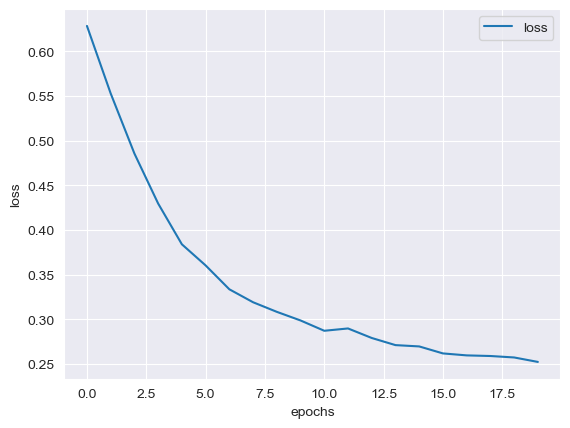

In [23]:
if r:
    plt.plot(r.history['loss'], label='loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Save the model weights</h3>
</div>

In [25]:
model_path = get_directory('model_path')

weights_file=os.path.join(model_path, 'model_weights.h5')
model.model.save_weights(weights_file)
